In [1]:
%%HTML
<style>
body {
  #background-color: #FFFAFA !important;
  border-bottom: solid 10px #F4BD2F !important;
}
</style> 

# 機械学習による回帰(Regression)ケーススタディ


 #### 本ケーススタディのステップ

 - Step1 データ内容確認・可視化
 - Step2 データ前処理
 - Step3 モデル構築・検証
 - Step4 最適モデルによる結果確認  

#### 今回試行する回帰モデル

|モデル|内容|使用ライブラリ|
|:-----:|:--------:|:--------:|
|**決定木**|ツリー状の分岐処理で最も説明力の高いものを採用|[sklearn.tree.DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)|
|**ランダムフォレスト**|複数の決定木の多数決で回帰|[sklearn.ensemble.RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor)|
|**XGBoost**|勾配ブースティングによる決定木の構築|[xgboost.XGBRegressor](https://github.com/dmlc/xgboost)|
|**k近傍法**|説明変数に最も近い教師データによる回帰|[sklearn.neighbors.KNeighborsRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)|
|**サポートベクターマシン**|データ分類の境界線をマージンが最小になるように定める手法|[sklearn.svm.SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

### Step1 データ内容確認・可視化

#### 対象データセット：Death in the United States

 - https://www.kaggle.com/cdc/mortality
 - 米国CDC(Centers for Disease Control and Prevention)による公開データ
 - ライセンス：CC0 public domain
 - 英国IFAレポート["Practical Application of Machine Learning Within Actuarial Work"](https://www.actuaries.org.uk/practice-areas/general-insurance/disbanded-research-working-parties/modelling-analytics-and-insights-data)でも検討
 - 本ケーススタディでは、2015年の米国内死者データから30000件抽出したものを使用します

##### （参考）英国IFA (Institution and Faculty of Actuaries) Working Party "Modelling, Analytics and Insights from Data"
 - 前述のレポート以外にも、データ分析にかかる有用な情報が提供されています（[リンク](https://www.actuaries.org.uk/practice-areas/general-insurance/disbanded-research-working-parties/modelling-analytics-and-insights-data)）

#### 1-1 データ読込
 - `pandas`の`read_csv`関数を用いてcsvファイルを読み込みます

In [2]:
# 基本的なライブラリをインポート
import numpy as np
import pandas as pd
# 元データ読込
df_raw =  pd.read_csv('https://storage.googleapis.com/cdc1/cdc_2015_mls2.csv')

#### 1-2 データ分割
 - 本ケーススタディでは全データ(30000件)を、学習用データ（24000件）とテスト用データ(6000件)に分割して使用します。
 - データ分割にあたって、「上からXX行」という方法は極力避けるべきです。ここでは`scikit-learn`の`train_test_split`を使用します。

In [3]:
#データ分割
from sklearn.model_selection import train_test_split
df_train,  df_test, _, _ = train_test_split(df_raw, df_raw, test_size=0.2, random_state=2018)

#### 1-3 データの全体像を確認（DataFrameクラス関数を使用）
 - まずはデータの全体像を確認しましょう
 - pandasのDataFrameクラスには、当該DataFrameの全体像を把握するための関数が複数存在します

|DataFrameクラス関数|内容|
|:-----:|:--------:|
|**`df.info()`**|行数・列数やメモリ使用量などの情報を表示|
|**`df.head(n)`**|最初のn行を表示|
|**`df.describe()`**|各列の情報を表示|

In [4]:
# 行数・列数やメモリ使用量などの情報を表示
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 22659 to 9466
Data columns (total 11 columns):
Jusho          24000 non-null int64
Education      23308 non-null float64
Sex            24000 non-null object
Marital        24000 non-null object
Death_Place    24000 non-null int64
Injury         24000 non-null object
Death_Cause    20486 non-null float64
Disposition    24000 non-null object
Month          24000 non-null int64
Week           24000 non-null int64
Age            24000 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 2.2+ MB


#### データ定義を確認

 - 各フィールドの定義は以下のとおり ([CDCwebsite](https://www.cdc.gov/nchs/nvss/mortality_public_use_data.htm)より。講義用に修正。)
 - 今回は回帰モデルケーススタディなので、数値フィールドである`Age`（死亡時年齢）を目的変数とします（IFAレポートのケーススタディと同様）

|field|content|
|:-----:|:--------:|
|Jusho|死亡者住所。1-Residents, 2-Intrastate Nonresidents, 3-Interstate Nonresidents, 4-Foreign Residents  |
|Education|1-8th grade or less, 2-9~12th grade, no diploma, 3-highschool graduate or GED completed, 4-some college credit, but no degree, 5- Associate degree, 6-Bachelor's degree, 7-Masger's degree, 8-Doctorate or professional degree, 9-Unknown|
|Sex|M-Male, F-Female|
|Marital|S-Never married, single, M- Married, W-Widowed, D-Divorced, U-Unknown|
|Death_Place|死亡場所。1-Hospital, impatient, 2-Hospital, outpatient, 3-Hospital, dead on arriva, 4-Decedent's home, 5-Hospice facility, 6-Nursing home, 7-Other, 9-unknown|
|Injury|Y-Yes, N-No, U-Unknown|
|Death_Cause|死因。1-Accident, 2-Suicide, 3-Homicide, 4-Pending investigation, 5- Could not determine, 6-Self-inflicted, 7-Natural, Blank-Not specified|
|Disposition|葬法。B-Burial, C-Cremation, O-Other, U-Unknown|
|Month|死亡月。|
|Week|死亡週。1-Sun, 2-Mon, 3-Tue, 4-Wed, 5-Thu, 6-Fri, 7-Sat, 9-Unknown|
|**Age**|死亡時年齢 (= **目的変数**)|


In [5]:
# 最初のn行を表示
df_train.head(10)

,Jusho,Education,Sex,Marital,Death_Place,Injury,Death_Cause,Disposition,Month,Week,Age
22659,2,3.0,M,M,1,U,7.0,C,11,6,63
6618,1,2.0,M,D,1,U,7.0,C,8,6,53
26605,1,NaN,F,W,1,U,7.0,U,8,7,94
2504,1,1.0,F,W,4,U,7.0,B,5,3,87
1111,1,3.0,M,S,5,U,7.0,B,3,1,67
15716,1,7.0,F,S,4,U,NaN,B,11,4,66
15010,1,NaN,F,W,4,U,7.0,U,1,4,84
12642,1,3.0,M,S,7,N,1.0,C,12,1,46
1164,1,5.0,F,M,4,U,7.0,C,9,7,92
10374,1,2.0,M,M,4,U,7.0,C,11,2,52


In [6]:
# 各列の情報を表示（特にmin/maxをチェック）
df_train.describe()

,Jusho,Education,Death_Place,Death_Cause,Month,Week,Age
count,24000.000000,23308.000000,24000.000000,20486.000000,24000.000000,24000.000000,24000.000000
mean,1.226042,3.705337,3.606500,6.482720,6.382208,4.011000,73.129667
std,0.497367,1.966535,2.068172,1.618079,3.516221,2.004652,18.011208
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,3.000000,1.000000,7.000000,3.000000,2.000000,63.000000
50%,1.000000,3.000000,4.000000,7.000000,6.000000,4.000000,77.000000
75%,1.000000,5.000000,6.000000,7.000000,9.000000,6.000000,87.000000
max,4.000000,9.000000,9.000000,7.000000,12.000000,9.000000,108.000000


#### 1-4 データ全体像把握の結果

以下の欠損値処理が必要
 - `education` : Naがあるので、'U' (Unknown) に置換  
 - `manner_of_death` : Blankがあるので、'8' (新規)に置換  

In [7]:
# DataFrameクラス関数で欠損値を置換
df_train2 = df_train.fillna({'Education' : 'U', 'Death_Cause' : 8})
# きちんと置換できたことを確認
df_train2.info()
df_train2.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 22659 to 9466
Data columns (total 11 columns):
Jusho          24000 non-null int64
Education      24000 non-null object
Sex            24000 non-null object
Marital        24000 non-null object
Death_Place    24000 non-null int64
Injury         24000 non-null object
Death_Cause    24000 non-null float64
Disposition    24000 non-null object
Month          24000 non-null int64
Week           24000 non-null int64
Age            24000 non-null int64
dtypes: float64(1), int64(5), object(5)
memory usage: 2.2+ MB


,Jusho,Death_Place,Death_Cause,Month,Week,Age
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,1.226042,3.606500,6.704875,6.382208,4.011000,73.129667
std,0.497367,2.068172,1.588253,3.516221,2.004652,18.011208
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,7.000000,3.000000,2.000000,63.000000
50%,1.000000,4.000000,7.000000,6.000000,4.000000,77.000000
75%,1.000000,6.000000,7.000000,9.000000,6.000000,87.000000
max,4.000000,9.000000,8.000000,12.000000,9.000000,108.000000


#### 1-5 可視化用ライブラリのインポート
 - `matplotlib`と`seaborn`が一般的
 - スタイルを自由に設定可能（`seaborn-darkgrid`が個人的におすすめ。Rに慣れてる人は`ggplot`もあり）

In [8]:
# 描画にはmatplotlibとseabornを使用
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
#plt.style.use('ggplot')

#### 1-6 目的変数の挙動確認
 - まずは学習用データの目的変数（死亡時年齢）につき、想定外の挙動をしていないかヒストグラムでチェック
 - ヒストグラム描画の作法はいろいろあるが、DataFrameクラス関数(matploblibのwrapper)を用いるのが汎用性の面でオススメ

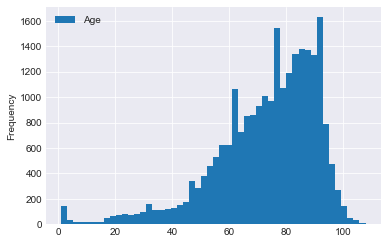

In [9]:
# ヒストグラム描画
name_obj = 'Age'
fig, ax = plt.subplots()
df_train2.plot(y=name_obj, kind='hist', bins=50, ax=ax)

#### 1-7 説明変数の分類（暫定）
- **説明変数の分類**を意識することが、今後の処理できわめて重要

|変数タイプ|内容|具体例|機械学習での取扱|  
|:---|:---|:---|:---|  
|**Numeric** |量的に測定された変数 （"差"に意味がある）　|長さ, 重さ, 時間, 回数, etc.　|　　正規化・標準化のうえモデル投入が一般的　|  
|**Categorical - ordinal** | 順序づけ可能な変数（ただし"差"に意味がない）　|成績（優/良/可）, 服のサイズ（L/M/S）, etc.　|　　Factorize（順序化）が一般的|  
|**Categorical - nominal** | 順序づけ不可能な変数　|性別, 商品名, etc.　|　　One-Hot Encodingが一般的　|  

In [10]:
# 説明変数名のリストを3つ作成
names_num = []
names_ord = ['Jusho']
names_nominal = ['Education','Sex','Marital','Death_Place','Injury','Death_Cause','Disposition']
# リストを3つつなげて説明変数名全体を作成
names_all = names_num + names_ord + names_nominal
# 以下の説明変数は不使用
names_unused = ['Month','Week']

#### 1-8 Categorical変数の可視化・検討
 - 各説明変数の分布の可視化（今回は省略）
 - **目的変数との相関関係の可視化** （重要な説明変数・異常な説明変数の識別のため）

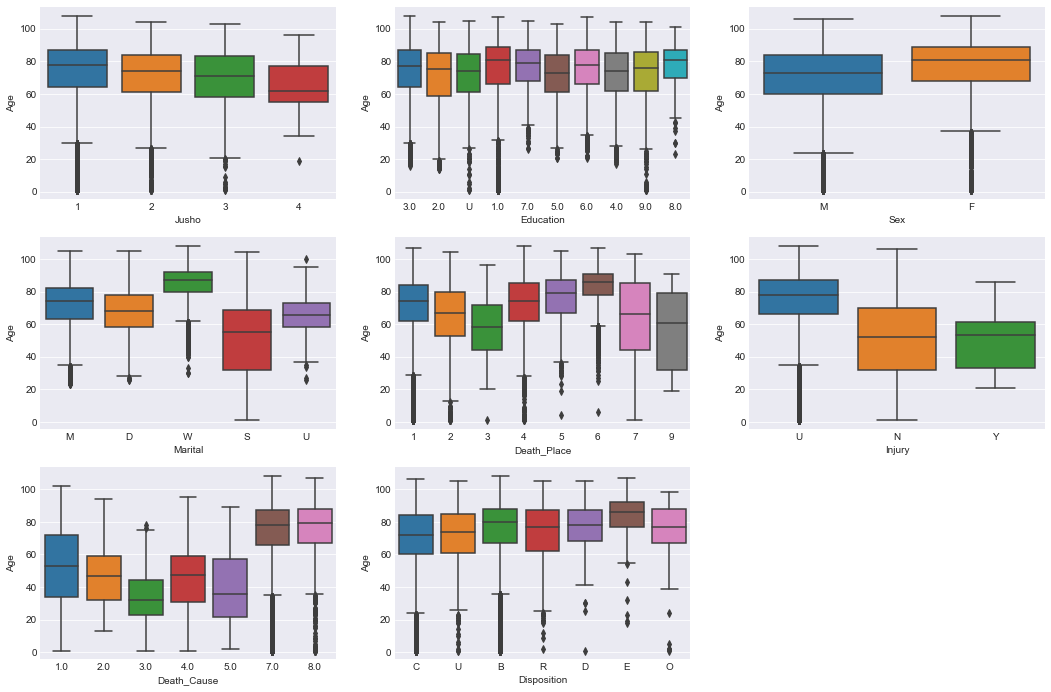

In [11]:
# 目的変数との相関関係の可視化（
fig = plt.figure(figsize=(18,12))
for i, name in enumerate(names_ord + names_nominal):
    ax = fig.add_subplot(3,3,i+1)
    sns.boxplot(data=df_train2, x=name, y=name_obj)

#### データ定義（再掲）

|field|content|
|:-----:|:--------:|
|Jusho|死亡者住所。1-Residents, 2-Intrastate Nonresidents, 3-Interstate Nonresidents, 4-Foreign Residents  |
|Education|1-8th grade or less, 2-9~12th grade, no diploma, 3-highschool graduate or GED completed, 4-some college credit, but no degree, 5- Associate degree, 6-Bachelor's degree, 7-Masger's degree, 8-Doctorate or professional degree, 9-Unknown|
|Sex|M-Male, F-Female|
|Marital|S-Never married, single, M- Married, W-Widowed, D-Divorced, U-Unknown|
|Death_Place|死亡場所。1-Hospital, impatient, 2-Hospital, outpatient, 3-Hospital, dead on arriva, 4-Decedent's home, 5-Hospice facility, 6-Nursing home, 7-Other, 9-unknown|
|Injury|Y-Yes, N-No, U-Unknown|
|Death_Cause|死因。1-Accident, 2-Suicide, 3-Homicide, 4-Pending investigation, 5- Could not determine, 6-Self-inflicted, 7-Natural, Blank-Not specified|
|Disposition|葬法。B-Burial, C-Cremation, O-Other, U-Unknown|
|**Age**|死亡時年齢 (= **目的変数**)|


### Step2 データ前処理


#### 2-1 データ分割
 - あらためてデータを作成します
 - 学習用データとテストデータに分ける前に、まずX（説明変数）とy（目的変数）に分割します

In [25]:
# 説明変数/目的変数分割 （Step1で識別した欠損値補間を忘れず）
X = df_raw[names_all].fillna({'Education' : 'U', 'Death_Cause' : 8})
y = df_raw[name_obj]

#### 2-2 Categorical-ordinal 変数処理
- 順序変数に変換
- `pandas`の`factorize`関数を使用
- 学習用データとテスト用データを別々に処理しないように注意

In [26]:
# names_ord処理 *セッション後修正。pd.mapで順番を特定するのが望ましい。(今回の設定では結果に影響なし)
# for name in names_ord:
#    X[name],temp = pd.factorize(X[name])

X[names_ord[0]] = X[names_ord[0]].map({4:0,3:1,2:2,1:3})

#### 2-3 Categorical-nominal 変数処理
 - One-Hot Encoding (= 0-1のダミー変数を追加）
 - `pandas`の`get_dummies`関数を使用
 - 学習用データとテスト用データを別々に処理しないように注意

In [27]:
# names_nominal処理
df_dummy = pd.get_dummies(X.astype(object)[names_nominal], drop_first=True)
X = pd.merge(X.drop(columns=names_nominal), df_dummy, left_index=True, right_index=True)

#### 出来上がったXはこんな感じ

In [28]:
X.head(10)

,Jusho,Education_2.0,Education_3.0,Education_4.0,Education_5.0,Education_6.0,Education_7.0,Education_8.0,Education_9.0,Education_U,...,Death_Cause_4.0,Death_Cause_5.0,Death_Cause_7.0,Death_Cause_8.0,Disposition_C,Disposition_D,Disposition_E,Disposition_O,Disposition_R,Disposition_U
0,3,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,3,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,3,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
5,2,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,3,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
7,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
9,2,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


#### 2-4 学習用データとテスト用データを分割
 - scikit-learnのtrain_test_split関数を使用

In [29]:
# scikit-learnのtrain_test_split関数で学習用データとテスト用データを分割
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)

In [30]:
# サイズ確認
print(X_train.shape) 
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24000, 36)
(6000, 36)
(24000,)
(6000,)


In [31]:
# 内容確認
X_train.head(10)

,Jusho,Education_2.0,Education_3.0,Education_4.0,Education_5.0,Education_6.0,Education_7.0,Education_8.0,Education_9.0,Education_U,...,Death_Cause_4.0,Death_Cause_5.0,Death_Cause_7.0,Death_Cause_8.0,Disposition_C,Disposition_D,Disposition_E,Disposition_O,Disposition_R,Disposition_U
22659,2,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
6618,3,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
26605,3,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2504,3,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1111,3,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
15716,3,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
15010,3,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
12642,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1164,3,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
10374,3,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


### Step3 予測モデル構築・検証





#### 今回試行する回帰モデル（再掲）

|モデル|内容|使用ライブラリ|
|:-----:|:--------:|:--------:|
|**決定木**|ツリー状の分岐処理で最も説明力の高いものを採用|[sklearn.tree.DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)|
|**ランダムフォレスト**|複数の決定木の多数決で回帰|[sklearn.ensemble.RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor)|
|**XGBoost**|勾配ブースティングによる決定木の構築|[xgboost.XGBRegressor](https://github.com/dmlc/xgboost)|
|**k近傍法**|説明変数に最も近い教師データによる回帰|[sklearn.neighbors.KNeighborsRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)|
|**サポートベクターマシン**|データ分類の境界線をマージンが最小になるように定める手法|[sklearn.svm.SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
|**多層パーセプトロン**|パーセプトロンを複数つないだ深層学習|[keras.wrappers.scikit_learn.KerasRegressor](https://keras.io/ja/scikit-learn-api/)

In [32]:
# 使うライブラリを一通りimport
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

/Applications/anaconda3/envs/flask/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### 3-0 モデル構築・検証方針
 - 学習用データ（24,000件）を3分割する3分割交差検証の方法を使用
 - 交差検証結果が最良のモデルにつき、テストデータに適用して妥当性を確認

In [33]:
# 3分割交差検証の分割 (sklearn.model_selection_StratifiedKFold())
skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
# 結果格納用リスト
list_result = []

#### 3-1 決定木

In [34]:
# 試行パラメータ
param_grid = {'max_depth': [1,3,5,10]}
# グリッドサーチ実行
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=skf)
grid_search.fit(X_train, y_train)
# 結果確認
print("Grid scores on development set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean_test_score, std_test_score, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_test_score,  std_test_score, params))
    list_result.append(['DecisionTree', mean_test_score,  std_test_score, params])    
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

/Applications/anaconda3/envs/flask/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Grid scores on development set:
0.225 (+/-0.006) for {'max_depth': 1}
0.417 (+/-0.005) for {'max_depth': 3}
0.460 (+/-0.007) for {'max_depth': 5}
0.472 (+/-0.008) for {'max_depth': 10}
Best parameters: {'max_depth': 10}
Best cross-validation: 0.471709291774509


#### 3-2 ランダムフォレスト

In [35]:
# 試行パラメータ
param_grid = {'n_estimators': [10,20,100]}
# グリッドサーチ実行
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=skf)
grid_search.fit(X_train, y_train)
# 結果確認
print("Grid scores on development set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean_test_score, std_test_score, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_test_score,  std_test_score, params))
    list_result.append(['RandomForest', mean_test_score,  std_test_score, params])    
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

/Applications/anaconda3/envs/flask/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Grid scores on development set:
0.445 (+/-0.012) for {'n_estimators': 10}
0.453 (+/-0.010) for {'n_estimators': 20}
0.456 (+/-0.010) for {'n_estimators': 100}
Best parameters: {'n_estimators': 100}
Best cross-validation: 0.456203823796403


#### 3-3 XGB


In [36]:
# 試行パラメータ
param_grid = {}
# グリッドサーチ実行
grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=skf)
grid_search.fit(X_train, y_train)
# 結果確認
print("Grid scores on development set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean_test_score, std_test_score, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_test_score,  std_test_score, params))
    list_result.append(['XGB', mean_test_score,  std_test_score, params])    
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

/Applications/anaconda3/envs/flask/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Grid scores on development set:
0.494 (+/-0.005) for {}
Best parameters: {}
Best cross-validation: 0.4944108444793055


#### 3-4 K近傍法



In [37]:
# 試行パラメータ
param_grid = {'n_neighbors': [1,2,3]}
# グリッドサーチ実行
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=skf)
grid_search.fit(X_train, y_train)
# 結果確認
print("Grid scores on development set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean_test_score, std_test_score, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_test_score,  std_test_score, params))
    list_result.append(['KNeibors', mean_test_score,  std_test_score, params])    
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

/Applications/anaconda3/envs/flask/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Grid scores on development set:
0.063 (+/-0.013) for {'n_neighbors': 1}
0.284 (+/-0.012) for {'n_neighbors': 2}
0.361 (+/-0.009) for {'n_neighbors': 3}
Best parameters: {'n_neighbors': 3}
Best cross-validation: 0.36093663264332654


#### 3-5 Support Vector Machine (SVM)

In [39]:
# 試行パラメータ
param_grid = {'C': [1]}
# グリッドサーチ実行
grid_search = GridSearchCV(SVR(), param_grid, cv=skf)
grid_search.fit(X_train, y_train)
# 結果確認
print("Grid scores on development set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean_test_score, std_test_score, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_test_score,  std_test_score, params))
    list_result.append(['SVM', mean_test_score,  std_test_score, params])    
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

/Applications/anaconda3/envs/flask/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Grid scores on development set:
0.451 (+/-0.005) for {'C': 1}
Best parameters: {'C': 1}
Best cross-validation: 0.45139022297976916


#### 3-6 モデル比較
 - 結果を並べてみましょう

In [40]:
for result in list_result:
    print(result)

['DecisionTree', 0.22540635832156067, 0.005791384323446243, {'max_depth': 1}]
['DecisionTree', 0.416780989930873, 0.0047376571201414065, {'max_depth': 3}]
['DecisionTree', 0.4602363036146241, 0.006938319290817361, {'max_depth': 5}]
['DecisionTree', 0.471709291774509, 0.007958166514588768, {'max_depth': 10}]
['RandomForest', 0.4452237788180162, 0.01187403664272697, {'n_estimators': 10}]
['RandomForest', 0.4528084132971014, 0.01020264880545644, {'n_estimators': 20}]
['RandomForest', 0.456203823796403, 0.009964539579515925, {'n_estimators': 100}]
['XGB', 0.4944108444793055, 0.005363634854488307, {}]
['KNeibors', 0.06342632152347956, 0.013183606291262211, {'n_neighbors': 1}]
['KNeibors', 0.2844650579246406, 0.012440798905376197, {'n_neighbors': 2}]
['KNeibors', 0.36093663264332654, 0.00926344217598509, {'n_neighbors': 3}]
['SVM', 0.45139022297976916, 0.005154078255022838, {'C': 1}]


今回の最適モデルはXGB（パラメータ設定なし）

### Step4 最適モデルによる予測
 - 選択したモデルをテストデータに適用し、妥当性をチェック

In [41]:
# 最適モデル構築
clf = XGBRegressor()
clf.fit(X_train, y_train)
# 最適モデルによるテストデータ予測
result = pd.DataFrame(clf.predict(X_test), columns=['result'])

In [42]:
# テストデータ予測結果を結合
results = pd.concat([df_test.reset_index(drop=True),result],axis=1)
results.head(10)

,Jusho,Education,Sex,Marital,Death_Place,Injury,Death_Cause,Disposition,Month,Week,Age,result
0,1,3.0,M,M,4,U,7.0,C,3,5,65,70.882561
1,1,3.0,M,M,4,U,7.0,C,10,2,71,70.882561
2,2,4.0,F,W,1,U,7.0,B,2,2,92,83.374397
3,1,2.0,F,W,6,U,NaN,B,3,3,85,89.190331
4,1,3.0,M,D,4,U,7.0,B,9,5,78,69.584740
5,2,1.0,M,S,1,U,7.0,C,1,7,1,45.746117
6,1,3.0,F,D,4,U,7.0,C,12,3,62,68.838593
7,1,6.0,M,M,4,U,7.0,C,5,7,54,73.435707
8,1,5.0,M,M,5,U,7.0,C,9,5,45,72.667107
9,1,1.0,F,M,1,U,7.0,C,4,2,45,69.194801


#### テストデータ予測結果の可視化

/Applications/anaconda3/envs/flask/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Applications/anaconda3/envs/flask/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


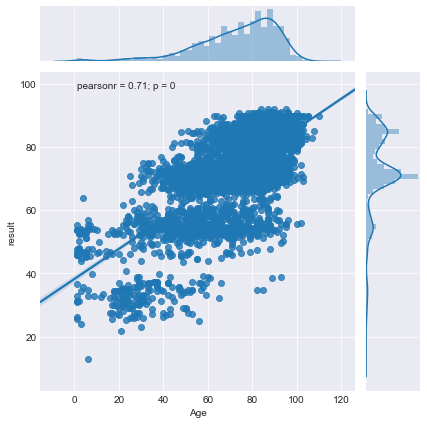

In [43]:
# seabornのjointplot関数で散布図を確認
sns.jointplot(name_obj,'result', data=results, kind='reg')

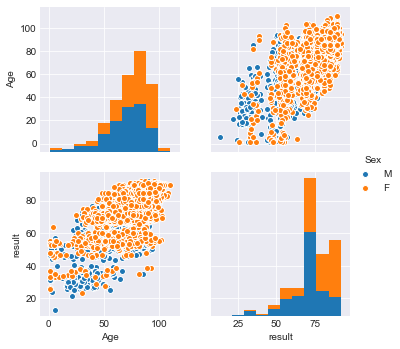

In [44]:
# 特定の説明変数で色分けした散布図も確認可能（seaborn.pairplotが便利）
sns.pairplot(results[[name_obj,'result', 'Sex']], hue='Sex')

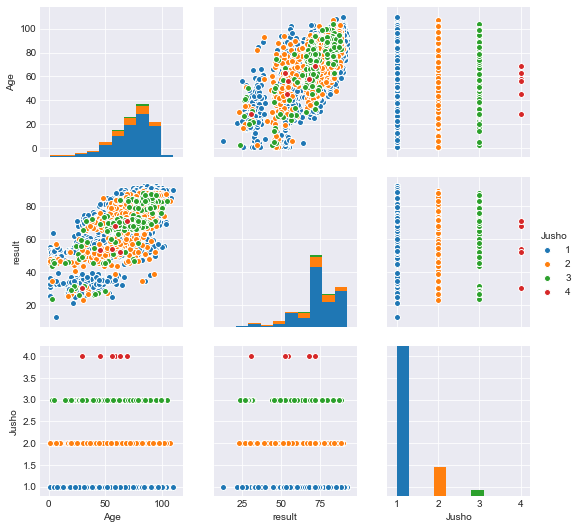

In [45]:
sns.pairplot(results[[name_obj,'result', 'Jusho']], hue='Jusho')